## Setup modules

In [1]:
import numpy as np
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
import dolfin as dl
dl.set_log_level(40)
from forward_solve import Fin, get_space
import pandas as pd

# MUQ Includes
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

%env HDF5_DISABLE_VERSION_CHECK=1
from muq_mod_five_param import ROM_forward, DL_ROM_forward, FOM_forward

env: HDF5_DISABLE_VERSION_CHECK=1


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.8.16 when it was built against 1.10.2, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
import matplotlib.pyplot as plt

In [3]:
resolution = 40
r_fwd = ROM_forward(resolution, out_type="subfin_avg")
d_fwd = DL_ROM_forward(resolution, out_type="subfin_avg")
f_fwd = FOM_forward(resolution, out_type="subfin_avg")

#z_true = np.array([[0.15,0.4,0.2,0.3,0.8]])
#z_true = np.random.uniform(0.1,1, (1,5))
z_true = np.array([[0.41126864, 0.61789679, 0.75873243, 0.96527541, 0.22348076]])

V = get_space(resolution)
full_solver = Fin(V)
w, y, A, B, C = full_solver.forward_five_param(z_true[0,:])
qoi = full_solver.qoi_operator(w)
obsData = qoi

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Keras model weights loaded


In [4]:
def MCMC_sample(fwd):
    # Define prior
    logPriorMu = 0.5*np.ones(5)
    logPriorCov = 0.5*np.eye(5)

    logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

    # Likelihood
    noiseVar = 1e-4
    noiseCov = noiseVar*np.eye(obsData.size)
    likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

    # Posterior
    posteriorPiece = mm.DensityProduct(2)
    zPiece = mm.IdentityOperator(5)

    # Define graph
    graph = mm.WorkGraph()

    # Forward model nodes and edges
    graph.AddNode(zPiece, "z")
    graph.AddNode(fwd, "fwd")
    graph.AddEdge("z", 0, "fwd", 0)

    # Other nodes and edges
    graph.AddNode(likelihood, "Likelihood")
    graph.AddNode(logPrior, "Prior")
    graph.AddNode(posteriorPiece,"Posterior")
    
    graph.AddEdge("fwd", 0, "Likelihood", 0)
    graph.AddEdge("z", 0, "Prior", 0)
    graph.AddEdge("Prior",0,"Posterior",0)
    graph.AddEdge("Likelihood",0, "Posterior",1)

    problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

    proposalOptions = dict()
    proposalOptions['Method'] = 'AMProposal'
    proposalOptions['ProposalVariance'] = 1e-4
    proposalOptions['AdaptSteps'] = 1000
    proposalOptions['AdaptStart'] = 1000
    proposalOptions['AdaptScale'] = 0.01

    kernelOptions = dict()
    kernelOptions['Method'] = 'MHKernel'
    kernelOptions['Proposal'] = 'ProposalBlock'
    kernelOptions['ProposalBlock'] = proposalOptions

    options = dict()
    options['NumSamples'] = 10000
    options['ThinIncrement'] = 1
    options['BurnIn'] = 100
    options['KernelList'] = 'Kernel1'
    options['PrintLevel'] = 3
    options['Kernel1'] = kernelOptions

    mcmc = ms.SingleChainMCMC(options,problem)

    startPt = 0.5*np.ones(5)
    samps = mcmc.Run(startPt)

    sampMean = samps.Mean()
    print ("z_mean: {}".format(sampMean))
    print ("z_true: {}".format(z_true[0]))

    sampCov = samps.Covariance()
    print('\nSample Covariance = \n', sampCov)

    ess = samps.ESS()
    print('\nEffective Sample Size = \n', ess)

    mcErr = np.sqrt( samps.Variance() / ess)
    print('\nEstimated MC error in mean = \n', mcErr)
    
    sampMat = samps.AsMatrix()
    
    #plt.plot(sampMat.T)
    #plt.show()
    
    plt.figure(figsize=(30,30))
    df = pd.DataFrame(sampMat.T, columns=['$k_%d$'%i for i in range(5) ])

    pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.5)
    plt.show()
    return sampMat

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 12%
  20% Complete
    Block 0:
      Acceptance Rate = 10%
  30% Complete
    Block 0:
      Acceptance Rate = 20%
  40% Complete
    Block 0:
      Acceptance Rate = 27%
  50% Complete
    Block 0:
      Acceptance Rate = 31%
  60% Complete
    Block 0:
      Acceptance Rate = 34%
  70% Complete
    Block 0:
      Acceptance Rate = 36%
  80% Complete
    Block 0:
      Acceptance Rate = 38%
  90% Complete
    Block 0:
      Acceptance Rate = 40%
  100% Complete
    Block 0:
      Acceptance Rate = 42%
Completed in 970.437 seconds.
z_mean: [0.40087684 0.59340851 0.72367316 0.85252411 0.23615853]
z_true: [0.41126864 0.61789679 0.75873243 0.96527541 0.22348076]

Sample Covariance = 
 [[ 0.00025803  0.00059164  0.00072287  0.00191174 -0.00030354]
 [ 0.00059164  0.00154864  0.00194645  0.00497399 -0.00078118]
 [ 0.00072287  0.00194645  0.00265404  0.00651737 -0.0010142 ]
 [ 0.00191174  0.00497399  0.

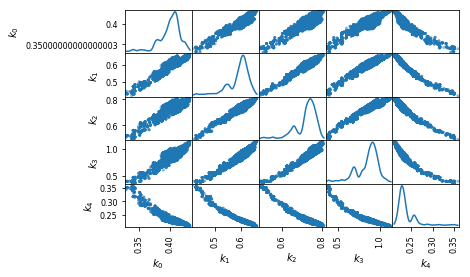

In [5]:
s_f = MCMC_sample(f_fwd)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 8.4%
  20% Complete
    Block 0:
      Acceptance Rate = 4.8%
  30% Complete
    Block 0:
      Acceptance Rate = 16%
  40% Complete
    Block 0:
      Acceptance Rate = 23%
  50% Complete
    Block 0:
      Acceptance Rate = 28%
  60% Complete
    Block 0:
      Acceptance Rate = 32%
  70% Complete
    Block 0:
      Acceptance Rate = 35%
  80% Complete
    Block 0:
      Acceptance Rate = 38%
  90% Complete
    Block 0:
      Acceptance Rate = 40%
  100% Complete
    Block 0:
      Acceptance Rate = 42%
Completed in 1005.7 seconds.
z_mean: [0.35174453 0.27696887 0.5908962  0.45114187 0.29079254]
z_true: [0.41126864 0.61789679 0.75873243 0.96527541 0.22348076]

Sample Covariance = 
 [[ 2.65489534e-05  4.75739538e-05 -3.34983637e-05  1.84937019e-06
  -1.38019015e-05]
 [ 4.75739538e-05  1.38001326e-04 -1.03566174e-04 -1.15314072e-05
  -3.79432736e-05]
 [-3.34983637e-05 -1.03566174e-04  1.11222502e-

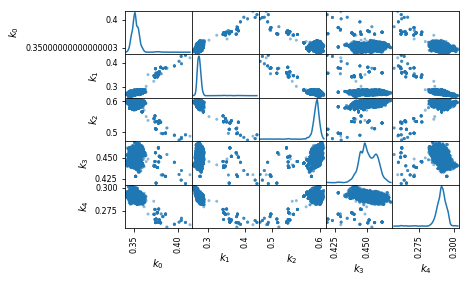

In [6]:
s_r = MCMC_sample(r_fwd)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 11%
  20% Complete
    Block 0:
      Acceptance Rate = 8.6%
  30% Complete
    Block 0:
      Acceptance Rate = 18%
  40% Complete
    Block 0:
      Acceptance Rate = 25%
  50% Complete
    Block 0:
      Acceptance Rate = 29%
  60% Complete
    Block 0:
      Acceptance Rate = 33%
  70% Complete
    Block 0:
      Acceptance Rate = 35%
  80% Complete
    Block 0:
      Acceptance Rate = 37%
  90% Complete
    Block 0:
      Acceptance Rate = 40%
  100% Complete
    Block 0:
      Acceptance Rate = 41%
Completed in 1064.56 seconds.
z_mean: [0.37586674 0.55780082 0.66053746 0.75473325 0.25208321]
z_true: [0.41126864 0.61789679 0.75873243 0.96527541 0.22348076]

Sample Covariance = 
 [[ 0.0001091   0.00028288  0.00028671  0.00077986 -0.00016034]
 [ 0.00028288  0.00091282  0.00088503  0.00234844 -0.00048347]
 [ 0.00028671  0.00088503  0.00099484  0.00253537 -0.00050945]
 [ 0.00077986  0.00234844  0

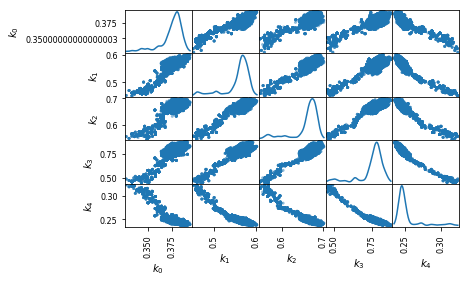

In [7]:
s_d = MCMC_sample(d_fwd)

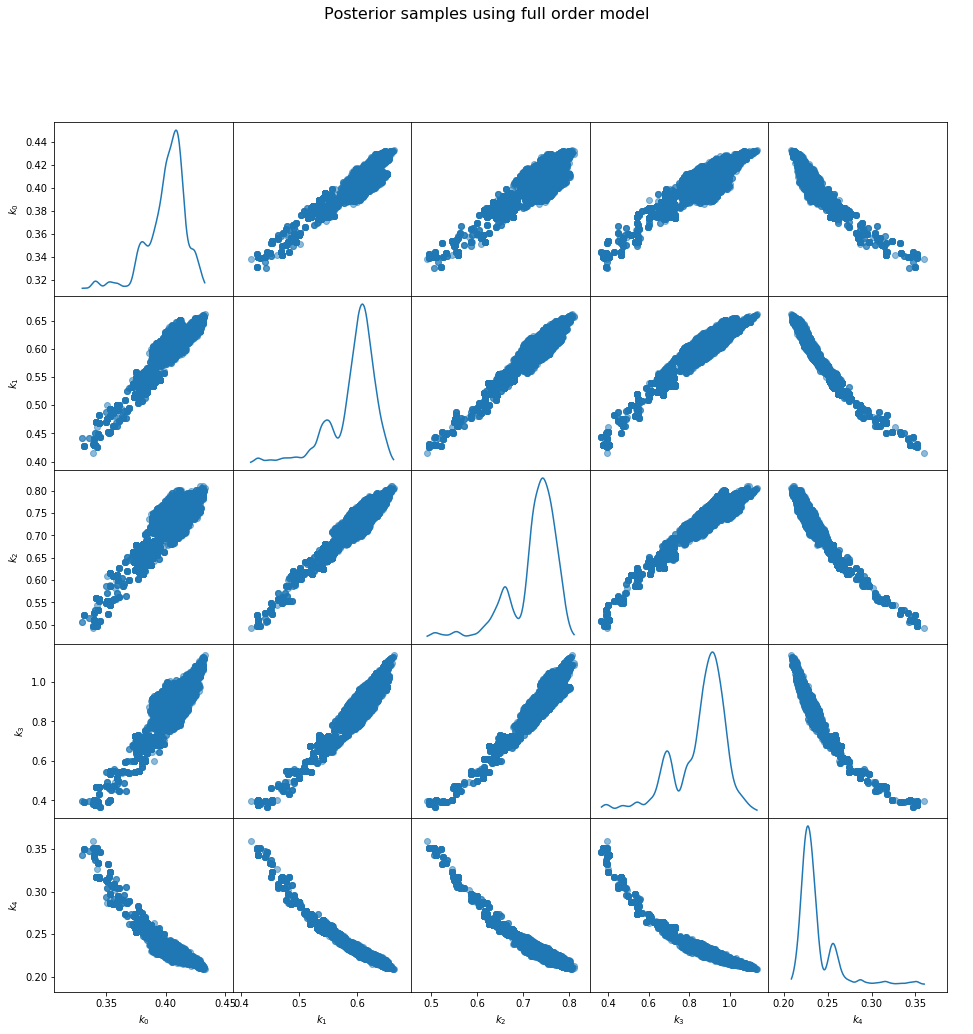

In [31]:
def scatter_matrix(df, axes=None, **kw):
    n = df.columns.size
    diagonal = kw.pop("diagonal", "hist")

    if not axes:
        fig, axes = plt.subplots(n,n, figsize=kw.pop("figsize", None), 
                                 squeeze=False, sharex="col", sharey="row")
    else:
        flax = axes.flatten()
        fig = flax[0].figure
        assert len(flax) == n*n

    # no gaps between subplots    
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle("Posterior samples using full order model", fontsize=16)
    
    hist_kwds = kw.pop("hist_kwds",  {})
    density_kwds = kw.pop("density_kwds",  {})

    import itertools
    p = itertools.permutations(df.columns, r=2)
    n = itertools.permutations(np.arange(len(df.columns)), r=2)
    for (i,j), (y,x) in zip(n,p):
        axes[i,j].scatter(df[x].values, df[y].values, **kw)
        axes[i,j].tick_params(left=False, labelleft=False, 
                              bottom=False, labelbottom=False)

    diagaxes = []
    for i, c in enumerate(df.columns):

        ax = axes[i,i].twinx()
        diagaxes.append(ax)

        if diagonal == 'hist':
            ax.hist(df[c].values, **hist_kwds)

        elif diagonal in ('kde', 'density'):
            from scipy.stats import gaussian_kde
            y = df[c].values
            gkde = gaussian_kde(y)
            ind = np.linspace(y.min(), y.max(), 1000)
            ax.plot(ind, gkde.evaluate(ind), **density_kwds)

        if i!= 0:
            diagaxes[0].get_shared_y_axes().join(diagaxes[0], ax)
        ax.axis("off")


    for i,c in enumerate(df.columns):
        axes[i,i].tick_params(left=False, labelleft=False,
                               bottom=False, labelbottom=False)
        axes[i,0].set_ylabel(c)
        axes[-1,i].set_xlabel(c)
        axes[i,0].tick_params(left=True, labelleft=True)
        axes[-1,i].tick_params(bottom=True, labelbottom=True)


    return axes, diagaxes

#from matplotlib.ticker import FormatStrFormatter
df = pd.DataFrame(s_f.T, columns=['$k_%d$'%i for i in range(5) ])
scatter_matrix(df, figsize=(16,16), diagonal='kde', alpha=0.5)
plt.savefig("samps_fom.png", dpi=250)
#axes = pd.plotting.scatter_matrix(df, figsize=(16,16), diagonal='kde', alpha=0.5)
#for ax in axes.flatten():
#    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
#plt.savefig("samps_rom.png", dpi=250)

[9.04167938]


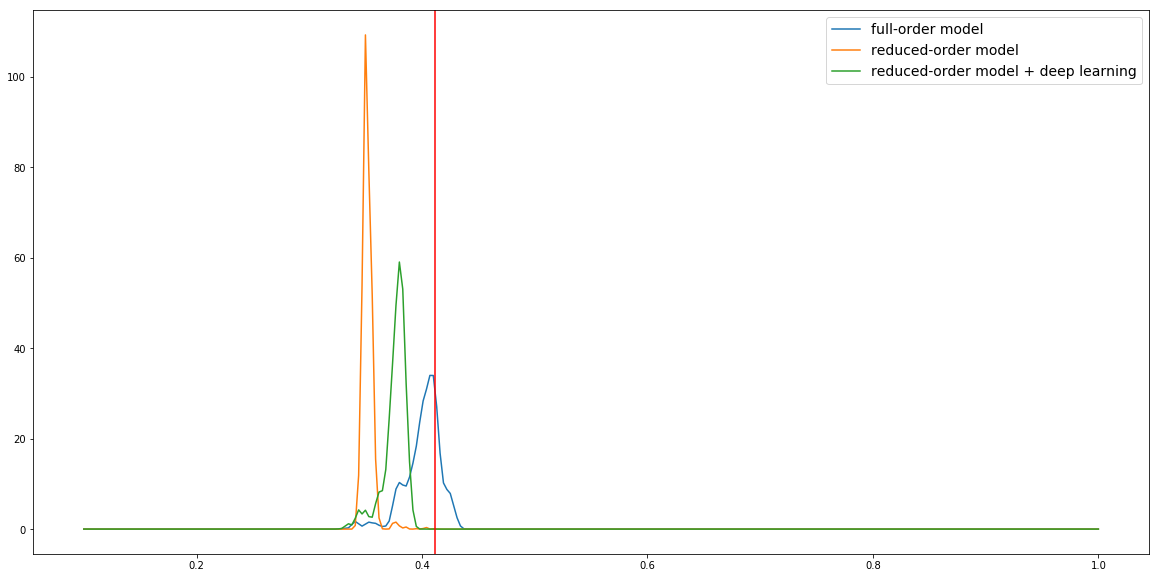

[0.3967943]


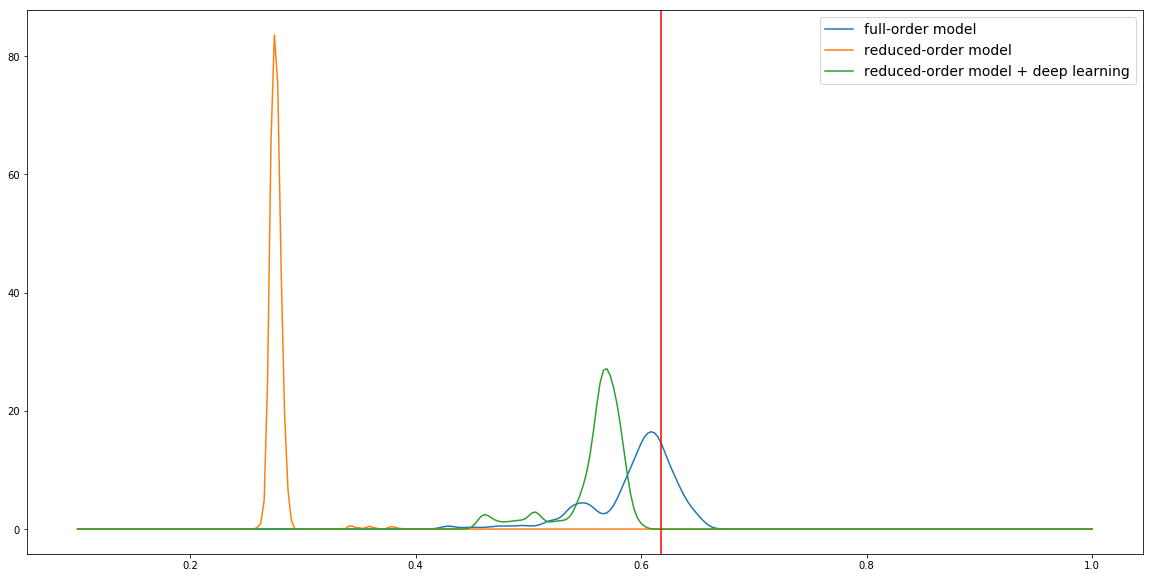

[0.]


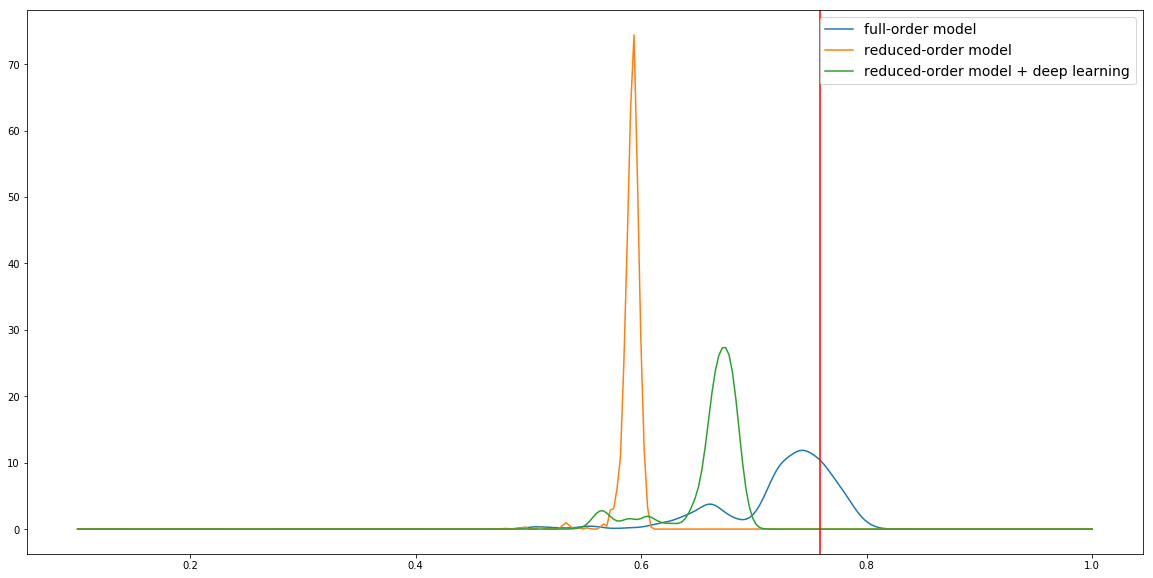

[0.]


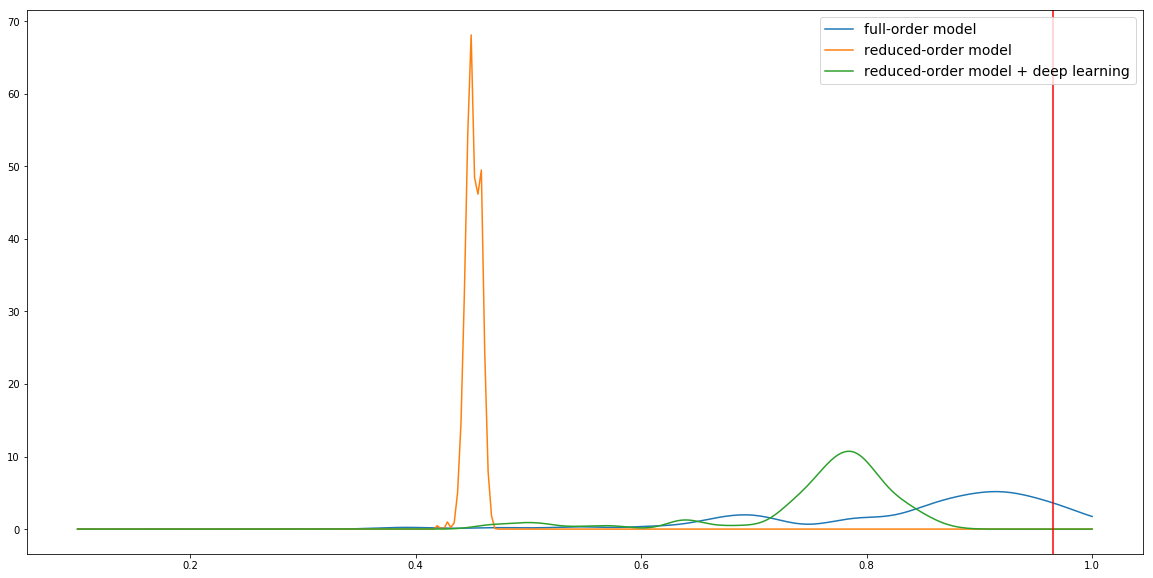

[0.]


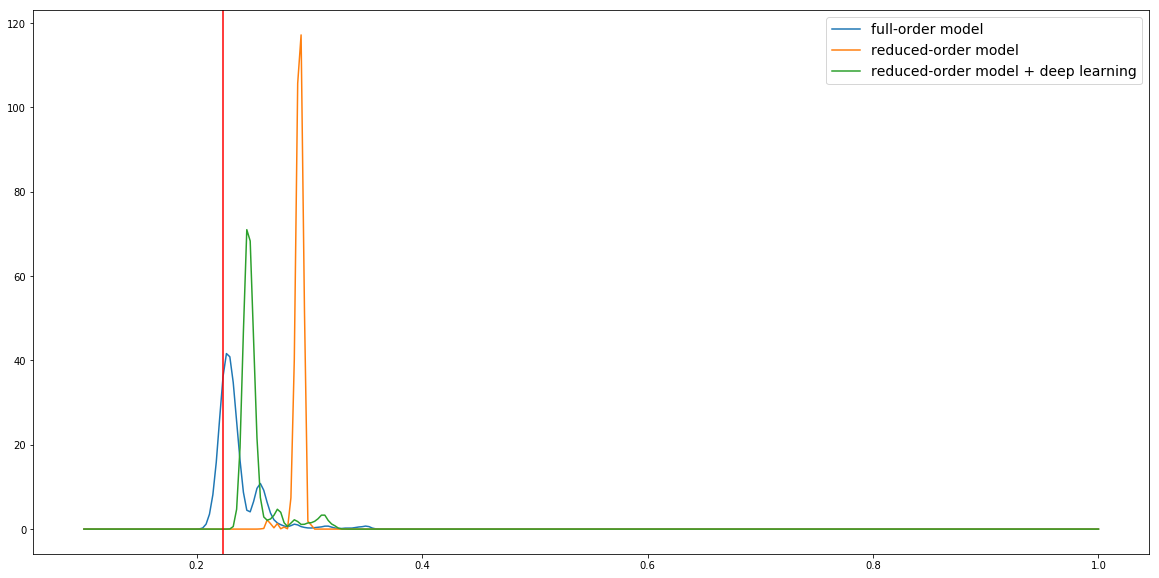

In [63]:
import scipy.stats as stats
def plot_post(s_f, s_r, s_d, true_vals):
    x = np.linspace(0.1, 1, 300)
    for i in range(5):
        plt.figure(figsize=(20,10))
        true = true_vals[i]
        density_f = stats.gaussian_kde(s_f[i])
        density_r = stats.gaussian_kde(s_r[i])
        density_d = stats.gaussian_kde(s_d[i])
        print(density_r(0.36))
        plt.plot(x, density_f.pdf(x)/density_f.integrate_box(0,1))
        plt.plot(x, density_r.pdf(x)/density_f.integrate_box(0,1))
        plt.plot(x, density_d.pdf(x)/density_f.integrate_box(0,1))
        plt.axvline(x=true,color='r')
        plt.legend(["full-order model", "reduced-order model", "reduced-order model + deep learning"], fontsize=14, loc=1)
        plt.xlabel("thermal conductivity")
        plt.ylbale("pdf")
        plt.show()
    
true_vals = np.array([0.41126864, 0.61789679, 0.75873243, 0.96527541, 0.223480755])
plot_post(s_f, s_r, s_d, true_vals)